In [54]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

pal = sns.color_palette("Reds_r")
sns.set_palette(pal)

In [55]:
# read in data

train_file = './train_users_2.csv.zip'
def zip_to_df(filepath):
    zfile = zipfile.ZipFile(filepath)
    for finfo in zfile.infolist():
        ifile = zfile.open(finfo)
        df = pd.read_csv(ifile)
    return df

df = zip_to_df(train_file)
        

In [56]:
df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [57]:
# Data clean up. 

df['gender'].replace('-unknown-', 'UNKNOWN', inplace=True)
df['gender'].replace(np.NaN, 'UNKNOWN', inplace=True)

# convert timestamp_first_active from string to datetime
df['timestamp_first_active'] = pd.to_datetime(df['timestamp_first_active'], format='%Y%m%d%H%M%S')

# set datetime values to datetime types
df['date_account_created'] = pd.to_datetime(df['date_account_created'])
df['date_first_booking'] = pd.to_datetime(df['date_first_booking'])


# the 'age' column has some extreme outliers and lots of missing values
# create a function for correcting values in age column, then apply
def check_age(age):
    if age in (np.nan, np.NaN):
        return np.NaN
    elif age >= 1000:
        # if age > 1000, I assume that the age value is actually birth year
        # subtract birth year from current year to calculate age
        return date.today().year - age
    else:
        return age
    
df['age'] = df['age'].apply(check_age)

# also add an age_group column

def age_group(age):
    if age in range(14):
        return '0-13'
    elif age in range(14,19):
        return '14-18'
    elif age in range(19, 26):
        return '19-25'
    elif age in range(26,36):
        return '26-35'
    elif age in range(36,51):
        return '36-50'
    elif age in range(51, 66):
        return '51-65'
    elif age > 65:
        return '66+'
    
    
df['age_group'] = df.age.apply(age_group)
df['age_group'].fillna('Unknown', inplace=True)
    
# calculate number of days to book 
df['days_to_book'] = df[df.country_destination != 'NDF'].date_first_booking - df[df.country_destination != 'NDF'].date_account_created
df['days_to_book'] = df.days_to_book.dt.days

# add device class column
def get_device_class(val):
    if str(val).lower().find('desktop') > 0:
        return 'Desktop'
    elif str(val).lower().find('phone') > 0:
        return 'Phone'
    elif val in ('iPad', 'Android Tablet'):
        return 'Tablet'
    else:
        return 'Unknown'

df['first_device_class'] = df['first_device_type'].apply(get_device_class)


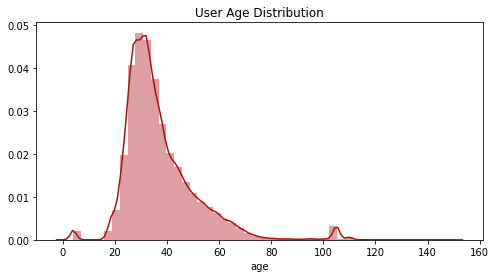

In [58]:
# Plot of age data after removing extreme (> 1000) outliers
plt.figure(figsize=(8,4))
sns.distplot(df.age.loc[df.age.isnull() == False])
plt.title('User Age Distribution')
plt.show()

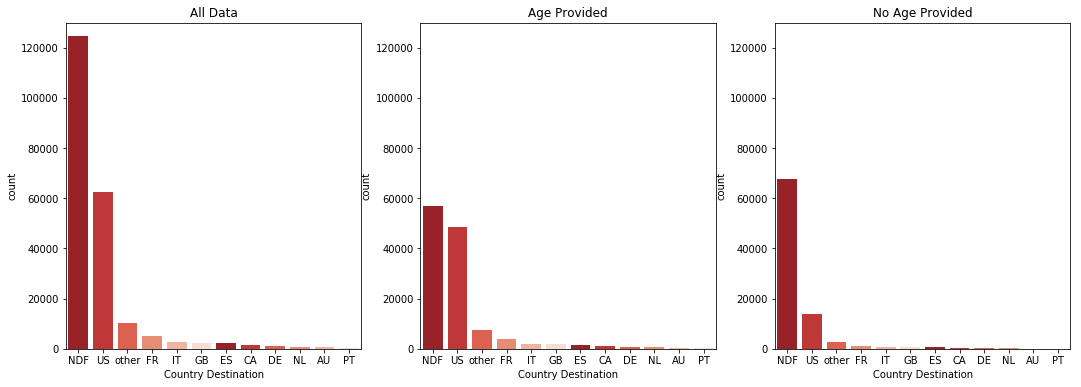

In [59]:
# Look at country destination by whether age is present or not
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)

sns.countplot(data=df,
              x='country_destination',
              order=df['country_destination'].value_counts().index, palette=pal)
plt.title('All Data')
plt.ylim(0,130000)
plt.xlabel('Country Destination')

plt.subplot(1,3,2)
sns.countplot(data=df.loc[df['age'].isnull() == False],
              x='country_destination',
              order=df['country_destination'].value_counts().index, palette=pal)
plt.title('Age Provided')
plt.ylim(0,130000)
plt.xlabel('Country Destination')


plt.subplot(1,3,3)
sns.countplot(data=df.loc[df['age'].isnull() == True],
              x='country_destination',
              order=df['country_destination'].value_counts().index, palette=pal)
plt.title('No Age Provided')
plt.ylim(0,130000)
plt.xlabel('Country Destination')

plt.show()
# the data indicates that having an age provided indicates a user is more likely to book a trip

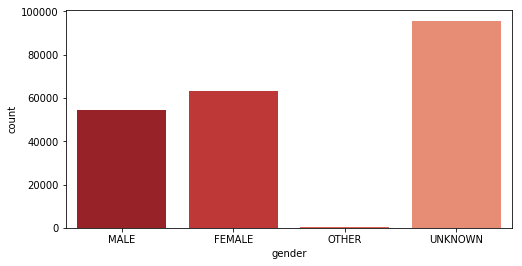

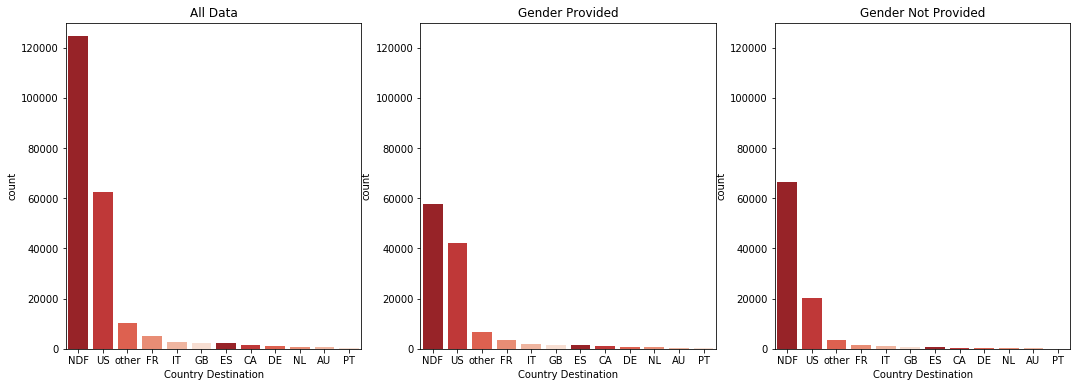

In [60]:
# "Unknown" age appears to be associated with NDF (no destination). Does an "Unknown" value for gender
# also correlate with no destination chosen?
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='gender', order=['MALE', 'FEMALE', 'OTHER', 'UNKNOWN'], palette=pal)
plt.show()

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.countplot(data=df,
              x='country_destination',
              order=df['country_destination'].value_counts().index, palette=pal)
plt.ylim(0,130000)
plt.title('All Data')
plt.xlabel('Country Destination')

plt.subplot(1,3,2)
sns.countplot(data=df.loc[df['gender'].isin(['MALE', 'FEMALE', 'OTHER'])],
              x='country_destination',
              order=df['country_destination'].value_counts().index, palette=pal)
plt.ylim(0,130000)
plt.title('Gender Provided')
plt.xlabel('Country Destination')

plt.subplot(1,3,3)
sns.countplot(data=df.loc[df['gender'] == 'UNKNOWN'],
              x='country_destination',
              order=df['country_destination'].value_counts().index, palette=pal)
plt.ylim(0,130000)
plt.title('Gender Not Provided')
plt.xlabel('Country Destination')

plt.show()
# Again we see that users who provide a gender appear to be more likely to book a trip
# though the correlation does not appear to be as strong as those users who provided/didn't provide an age

#adjust y-axes to same scale

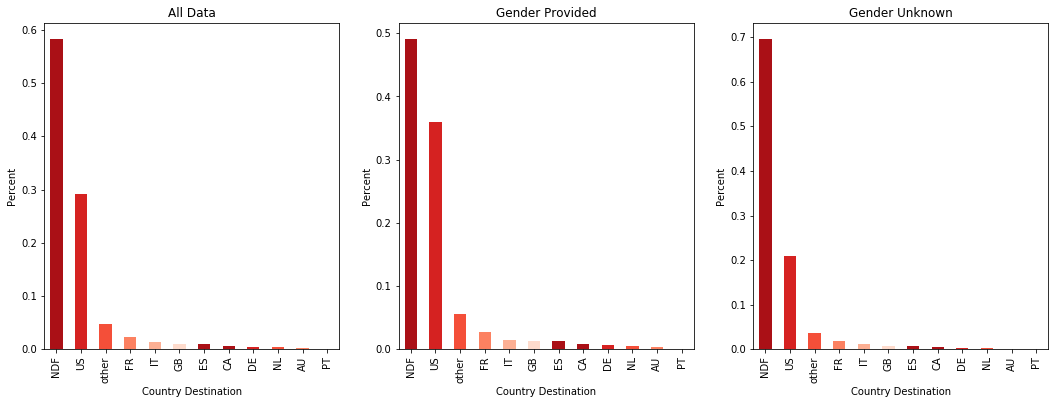

In [61]:
pct_unknown = df.loc[df['gender'] == 'UNKNOWN'][['gender', 'country_destination']]['country_destination'].value_counts() / len(df.loc[df['gender'] == 'UNKNOWN'])
pct_mf = df.loc[df['gender'].isin(['MALE', 'FEMALE', 'OTHER'])][['gender', 'country_destination']]['country_destination'].value_counts() / len(df.loc[df['gender'].isin(['MALE', 'FEMALE', 'OTHER'])])
pct_all = df[['gender', 'country_destination']]['country_destination'].value_counts() / len(df)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
pct_all.plot(kind='bar')
plt.xlabel('Country Destination')
plt.ylabel('Percent')
plt.title('All Data')

plt.subplot(1,3,2)
pct_mf.plot(kind='bar')
plt.xlabel('Country Destination')
plt.ylabel('Percent')
plt.title('Gender Provided')

plt.subplot(1,3,3)
pct_unknown.plot(kind='bar')
plt.xlabel('Country Destination')
plt.ylabel('Percent')
plt.title('Gender Unknown')


plt.show()

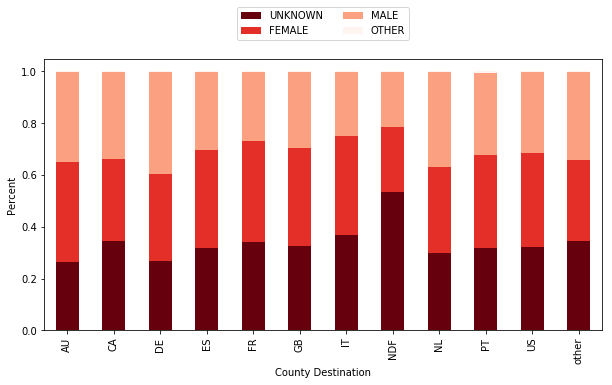

In [62]:
df6 = df.groupby('country_destination')['gender'].value_counts().unstack()

for ix in df6.index.values:
    df6.loc[ix] = df6.loc[ix] / len(df.loc[df.country_destination == ix])

df6 = df6[df['gender'].value_counts().index.tolist()]

_ = df6.plot(kind='bar', stacked=True, figsize=(10,5), legend=True, cmap=plt.cm.Reds_r)
_.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=2)
_.set_xlabel('County Destination')
_.set_ylabel('Percent')
plt.show()


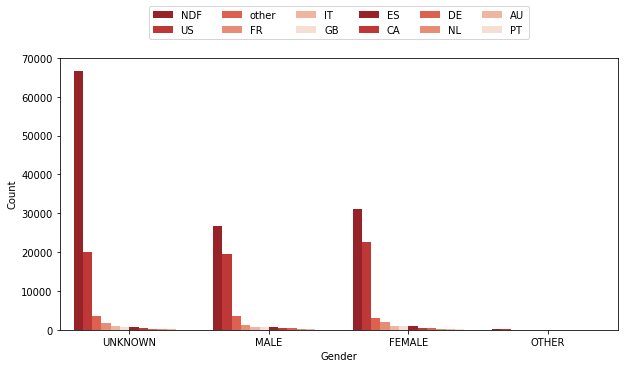

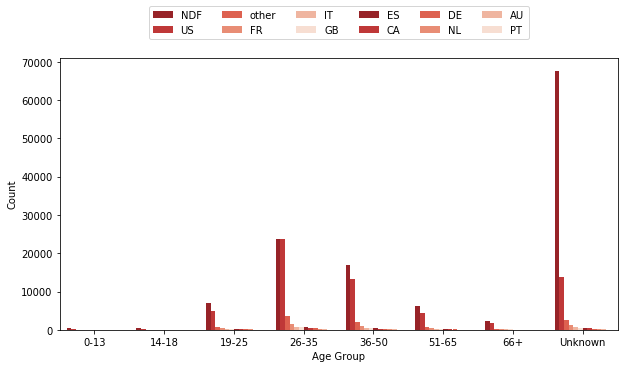

In [63]:
# Can age and gender be used to predict the destination?

#print(ggplot(d, aes(signup_app, Freq, fill=destination_country)) + geom_bar(stat="identity"))
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='gender', hue='country_destination', 
             hue_order=df['country_destination'].value_counts().index, palette=pal)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=6)
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='age_group', hue='country_destination', 
              hue_order=df['country_destination'].value_counts().index,
              order=['0-13', '14-18', '19-25', '26-35', '36-50', '51-65', '66+', 'Unknown'], palette=pal)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=6)
plt.show()

# these charts are hard to read. I need to come back and reformat as stacked bar graphs, which sadly
# isn't as easy or straightforward in seaborn as it is in ggplot2


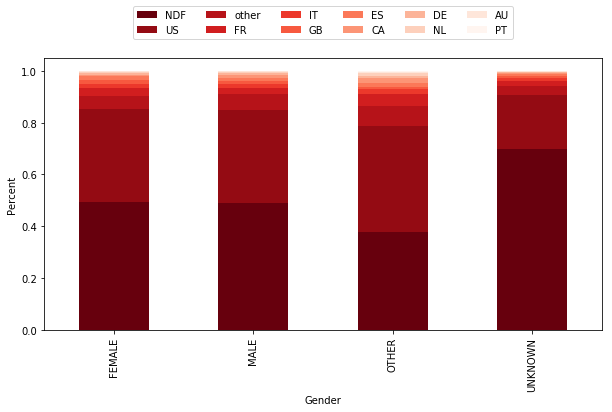

In [64]:
# get destination counts by gender
df2 = df.groupby('gender')['country_destination'].value_counts().unstack()
# create proportions
for ix in df2.index.values:
    df2.loc[ix] = df2.loc[ix] / len(df.loc[df.gender == ix])

df2 = df2[df['country_destination'].value_counts().index.tolist()]


_ = df2.plot(kind='bar', stacked=True, figsize=(10,5), legend=True, cmap=plt.cm.Reds_r)
_.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=6)
_.set_xlabel('Gender')
_.set_ylabel('Percent')
plt.show()

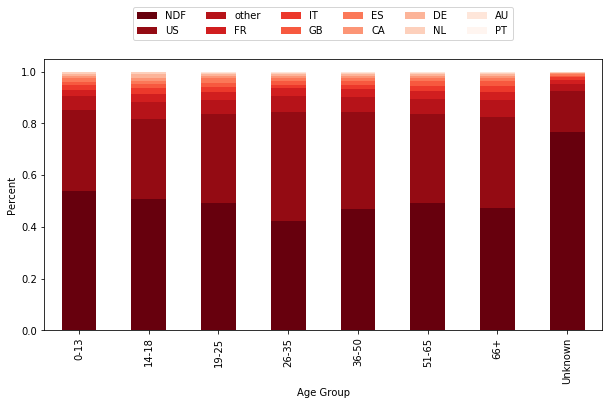

In [65]:
# get destination counts by age group
df3 = df.groupby('age_group')['country_destination'].value_counts().unstack()
# create proportions
for ix in df3.index.values:
    df3.loc[ix] = df3.loc[ix] / len(df.loc[df.age_group == ix])

df3 = df3[df['country_destination'].value_counts().index.tolist()]


_ = df3.plot(kind='bar', stacked=True, figsize=(10,5), legend=True, cmap=plt.cm.Reds_r)
_.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=6)
_.set_xlabel('Age Group')
_.set_ylabel('Percent')
plt.show()


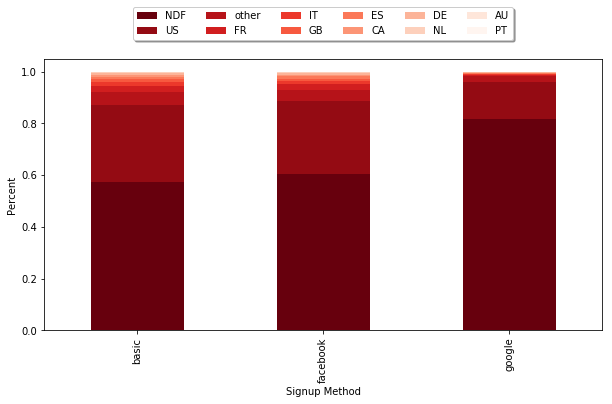

In [66]:
# get destinations by signup method
df4 = df.groupby('signup_method')['country_destination'].value_counts().unstack()

# get proportions
for ix in df4.index.values:
    df4.loc[ix] = df4.loc[ix] / len(df.loc[df.signup_method == ix])

df4 = df4[df['country_destination'].value_counts().index.tolist()]

_ = df4.plot(kind='bar', stacked=True, figsize=(10,5), legend=True, cmap=plt.cm.Reds_r)
_.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=6, fancybox=True, shadow=True)
_.set_xlabel('Signup Method')
_.set_ylabel('Percent')
plt.show()


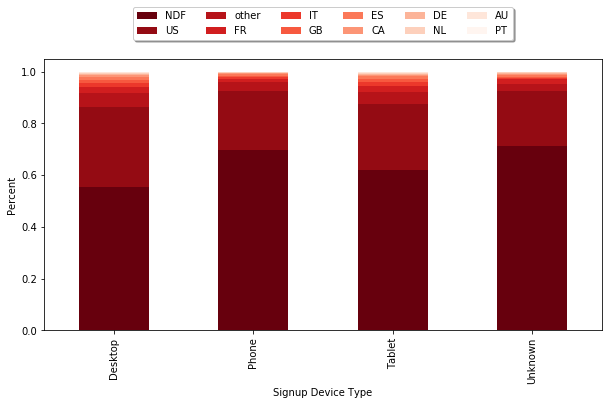

In [67]:
# get destinations by signup method
df5 = df.groupby('first_device_class')['country_destination'].value_counts().unstack()

# get proportions
for ix in df5.index.values:
    df5.loc[ix] = df5.loc[ix] / len(df.loc[df.first_device_class == ix])

df5 = df5[df['country_destination'].value_counts().index.tolist()]

_ = df5.plot(kind='bar', stacked=True, figsize=(10,5), legend=True, cmap=plt.cm.Reds_r)
_.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=6, fancybox=True, shadow=True)
_.set_xlabel('Signup Device Type')
_.set_ylabel('Percent')
plt.show()


In [68]:
df.loc[df['gender'].isin(['MALE', 'FEMALE', 'OTHER'])]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_group,days_to_book,first_device_class
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,36-50,NaN,Desktop
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,51-65,-57.0,Desktop
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,36-50,278.0,Desktop
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,36-50,3.0,Desktop
7,0d01nltbrs,2010-01-03,2010-01-03 19:19:05,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US,36-50,10.0,Desktop
8,a1vcnhxeij,2010-01-04,2010-01-04 00:42:11,2010-07-29,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,36-50,206.0,Desktop
10,yuuqmid2rp,2010-01-04,2010-01-04 19:42:51,2010-01-06,FEMALE,36.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Firefox,US,36-50,2.0,Desktop
11,om1ss59ys8,2010-01-05,2010-01-05 05:18:12,NaT,FEMALE,47.0,basic,0,en,other,craigslist,untracked,Web,iPhone,-unknown-,NDF,36-50,NaN,Phone
13,dy3rgx56cu,2010-01-05,2010-01-05 08:32:59,NaT,FEMALE,37.0,basic,0,en,other,craigslist,linked,Web,Mac Desktop,Firefox,NDF,36-50,NaN,Desktop
14,ju3h98ch3w,2010-01-07,2010-01-07 05:58:20,NaT,FEMALE,36.0,basic,0,en,other,craigslist,untracked,Web,iPhone,Mobile Safari,NDF,36-50,NaN,Phone


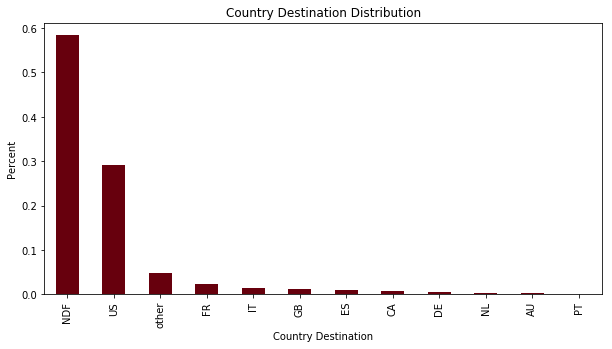

In [76]:
# one more thing. I want a plot showing value counts for each destination 
# as a percent of the total

country_pcts = df.country_destination.value_counts() / len(df)
_ = country_pcts.plot(kind='bar', cmap=plt.cm.Reds_r, 
                 figsize=(10,5), legend=False)
_ = plt.title('Country Destination Distribution')
_ = plt.xlabel('Country Destination')
_ = plt.ylabel('Percent')
plt.show()